# HW 7 - Visualization

## Task 1.
Visalise data from "Data'\LS_MS_NL folder. Try different approaches to visualize this data and describe the weak and strong points of each approach.

In [177]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

sns.set(style="whitegrid", context="talk")

In [178]:
directory = "../Data/LS_MS NL"
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

df_list = []

for file in csv_files:
    df = pd.read_csv(os.path.join(directory, file))

    def extract_amino_and_label(name):
        match = re.match(r'([A-Z]+)([+-]\d+)', name)
        if match:
            amino_acid = match.group(1)
            label = match.group(2)
            number = int(label[1:]) if label[0] == '+' else -int(label[1:])
            return amino_acid, number
        return None, None

    df[['amino_acid', 'isotopologue_number']] = pd.DataFrame(
        df['Name'].apply(extract_amino_and_label).tolist(), index=df.index
    )

    peak_area_cols = [col for col in df.columns if col.endswith('peak area')]

    amino_acid_to_col = {}
    for col in peak_area_cols:
        match = re.search(r'C13L_(\w+)\.CDF peak area', col)
        if match:
            amino_acid_to_col[match.group(1)] = col

    def get_peak_area(row):
        amino_acid = row['amino_acid']
        return row[amino_acid_to_col.get(amino_acid)] if amino_acid in amino_acid_to_col else None

    df['peak_area'] = df.apply(get_peak_area, axis=1)
    df['experiment'] = file 

    df_selected = df[['Name', 'amino_acid', 'isotopologue_number', 'peak_area', 'experiment']]
    df_list.append(df_selected)

In [179]:
df_all = pd.concat(df_list, ignore_index=True)
df_all['total_peak_area'] = df_all.groupby(['experiment', 'amino_acid'])['peak_area'].transform('sum')
df_all['relative_peak_area'] = df_all['peak_area'] / df_all['total_peak_area']

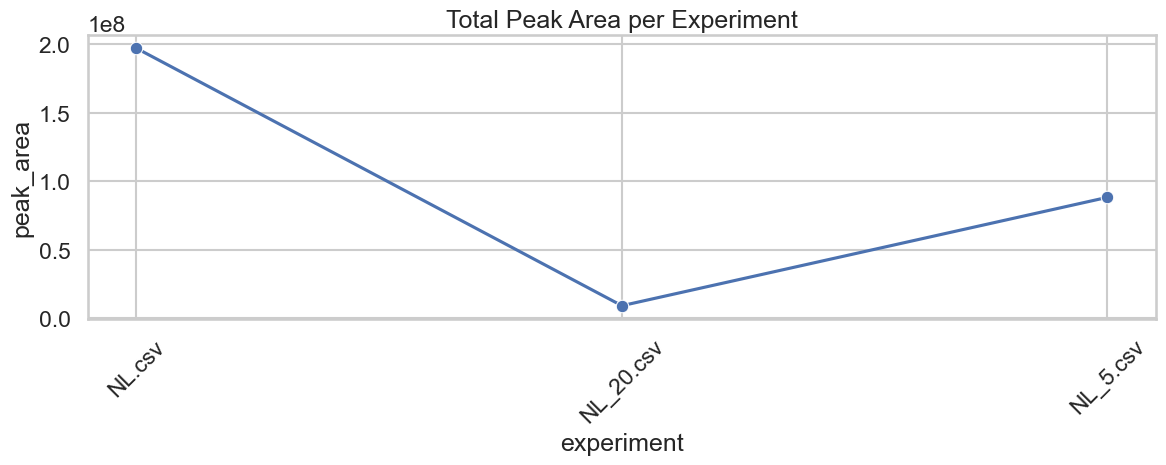

In [180]:
exp_trends = df_all.groupby(['experiment'])['peak_area'].sum().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=exp_trends, x='experiment', y='peak_area', marker='o')
plt.title("Total Peak Area per Experiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

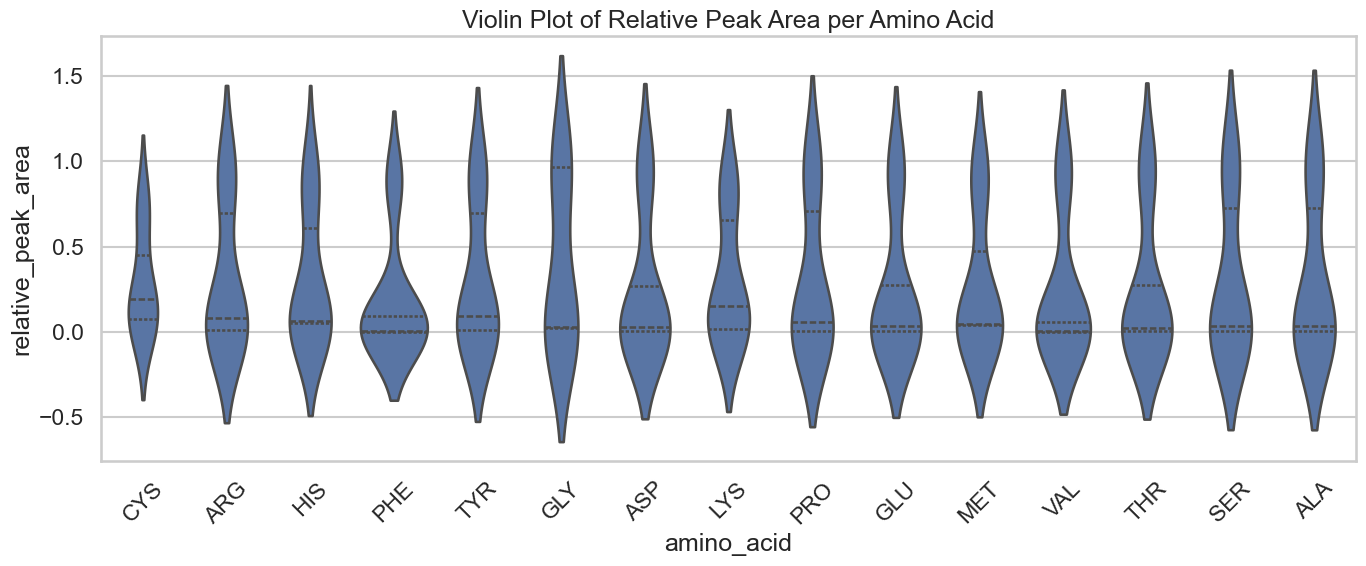

In [181]:
plt.figure(figsize=(14, 6))
sns.violinplot(data=df_all, x='amino_acid', y='relative_peak_area', inner='quartile', density_norm='count')
plt.title("Violin Plot of Relative Peak Area per Amino Acid")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

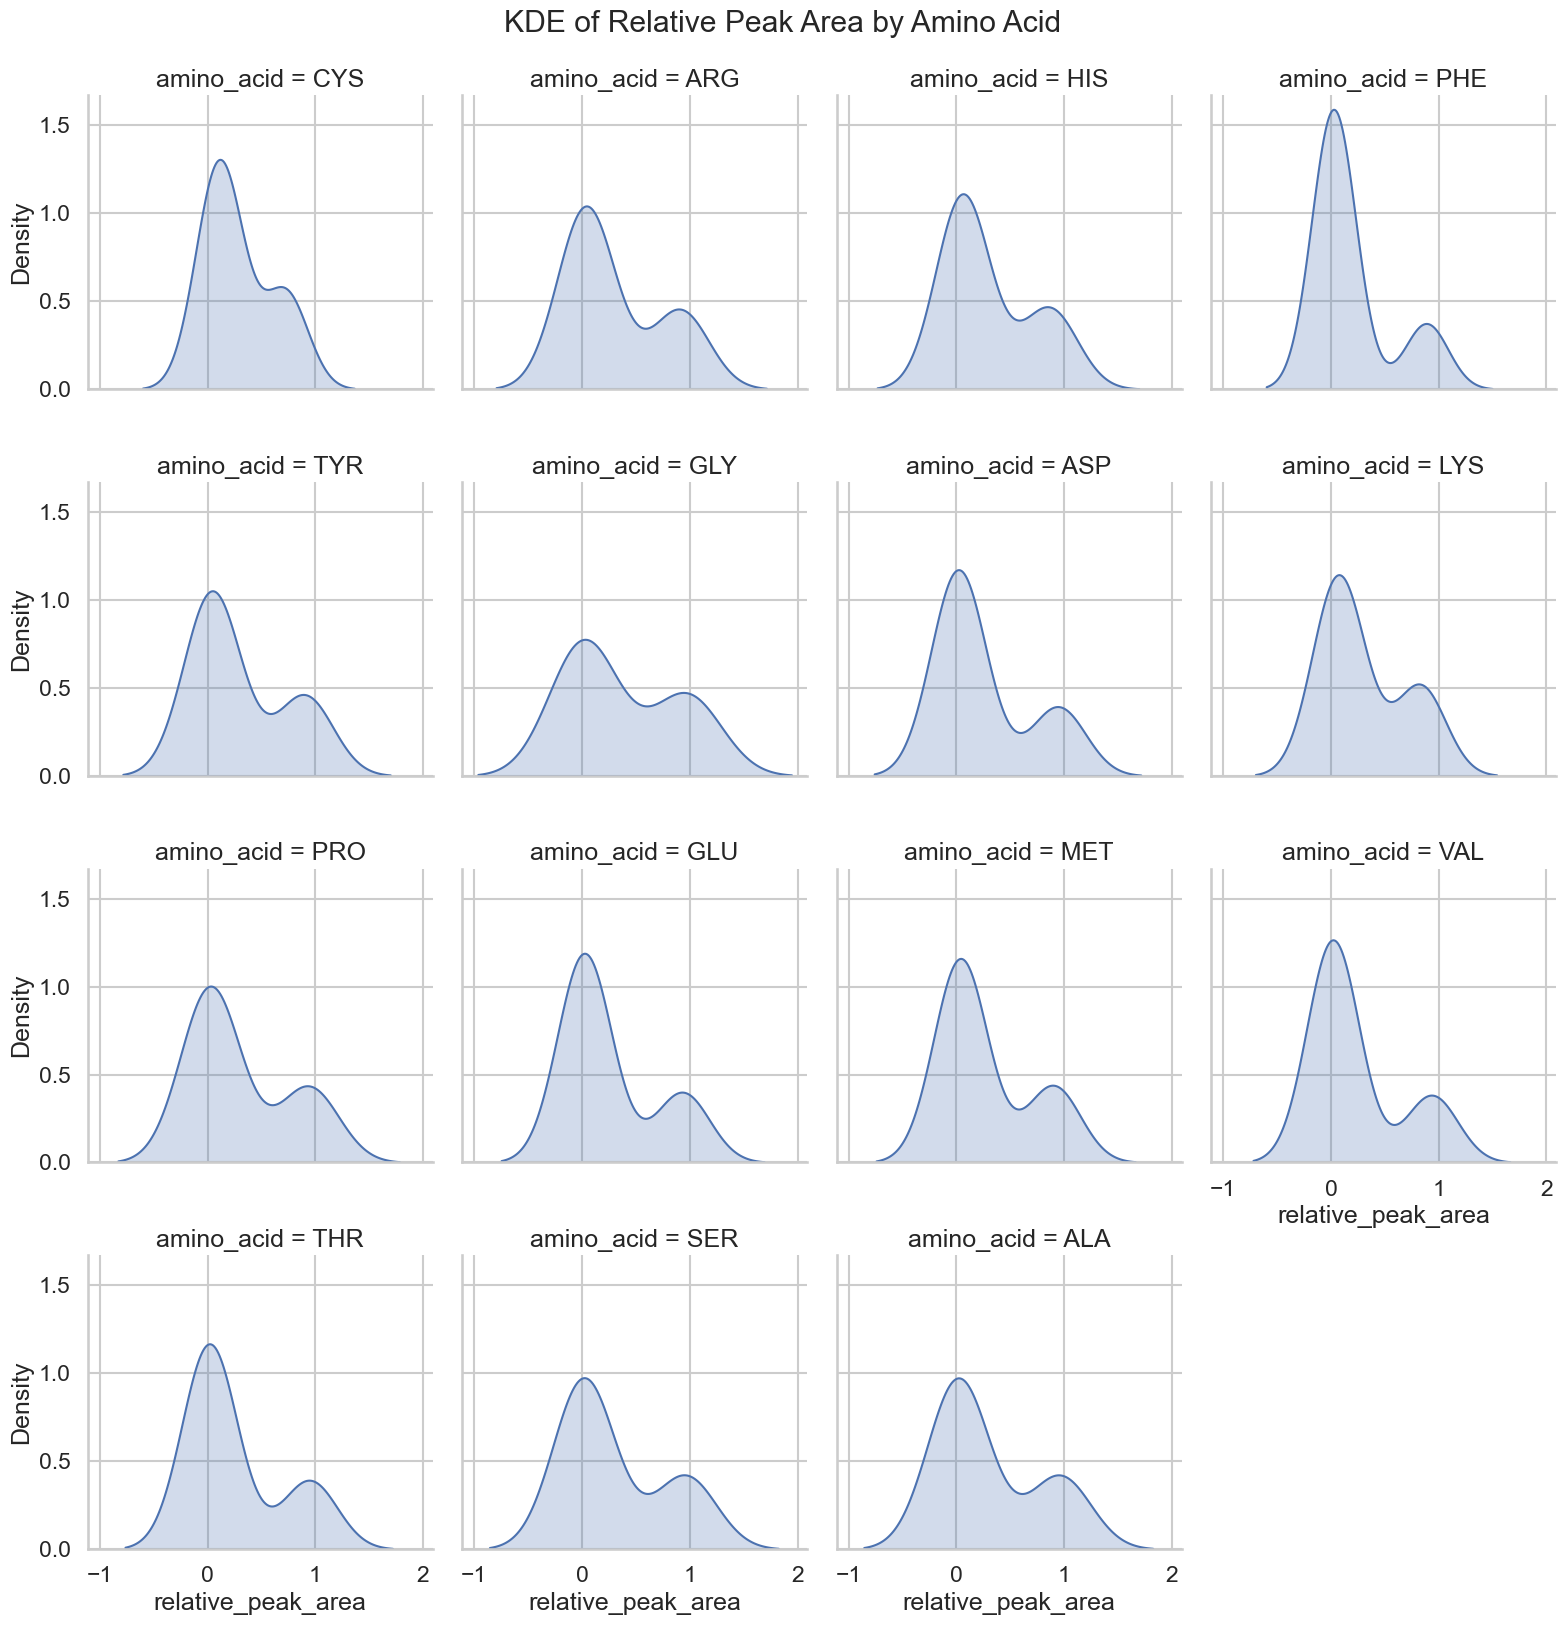

In [182]:
g = sns.FacetGrid(df_all, col="amino_acid", col_wrap=4, height=4)
g.map(sns.kdeplot, "relative_peak_area", fill=True)
g.fig.suptitle("KDE of Relative Peak Area by Amino Acid", y=1.02)
plt.show()

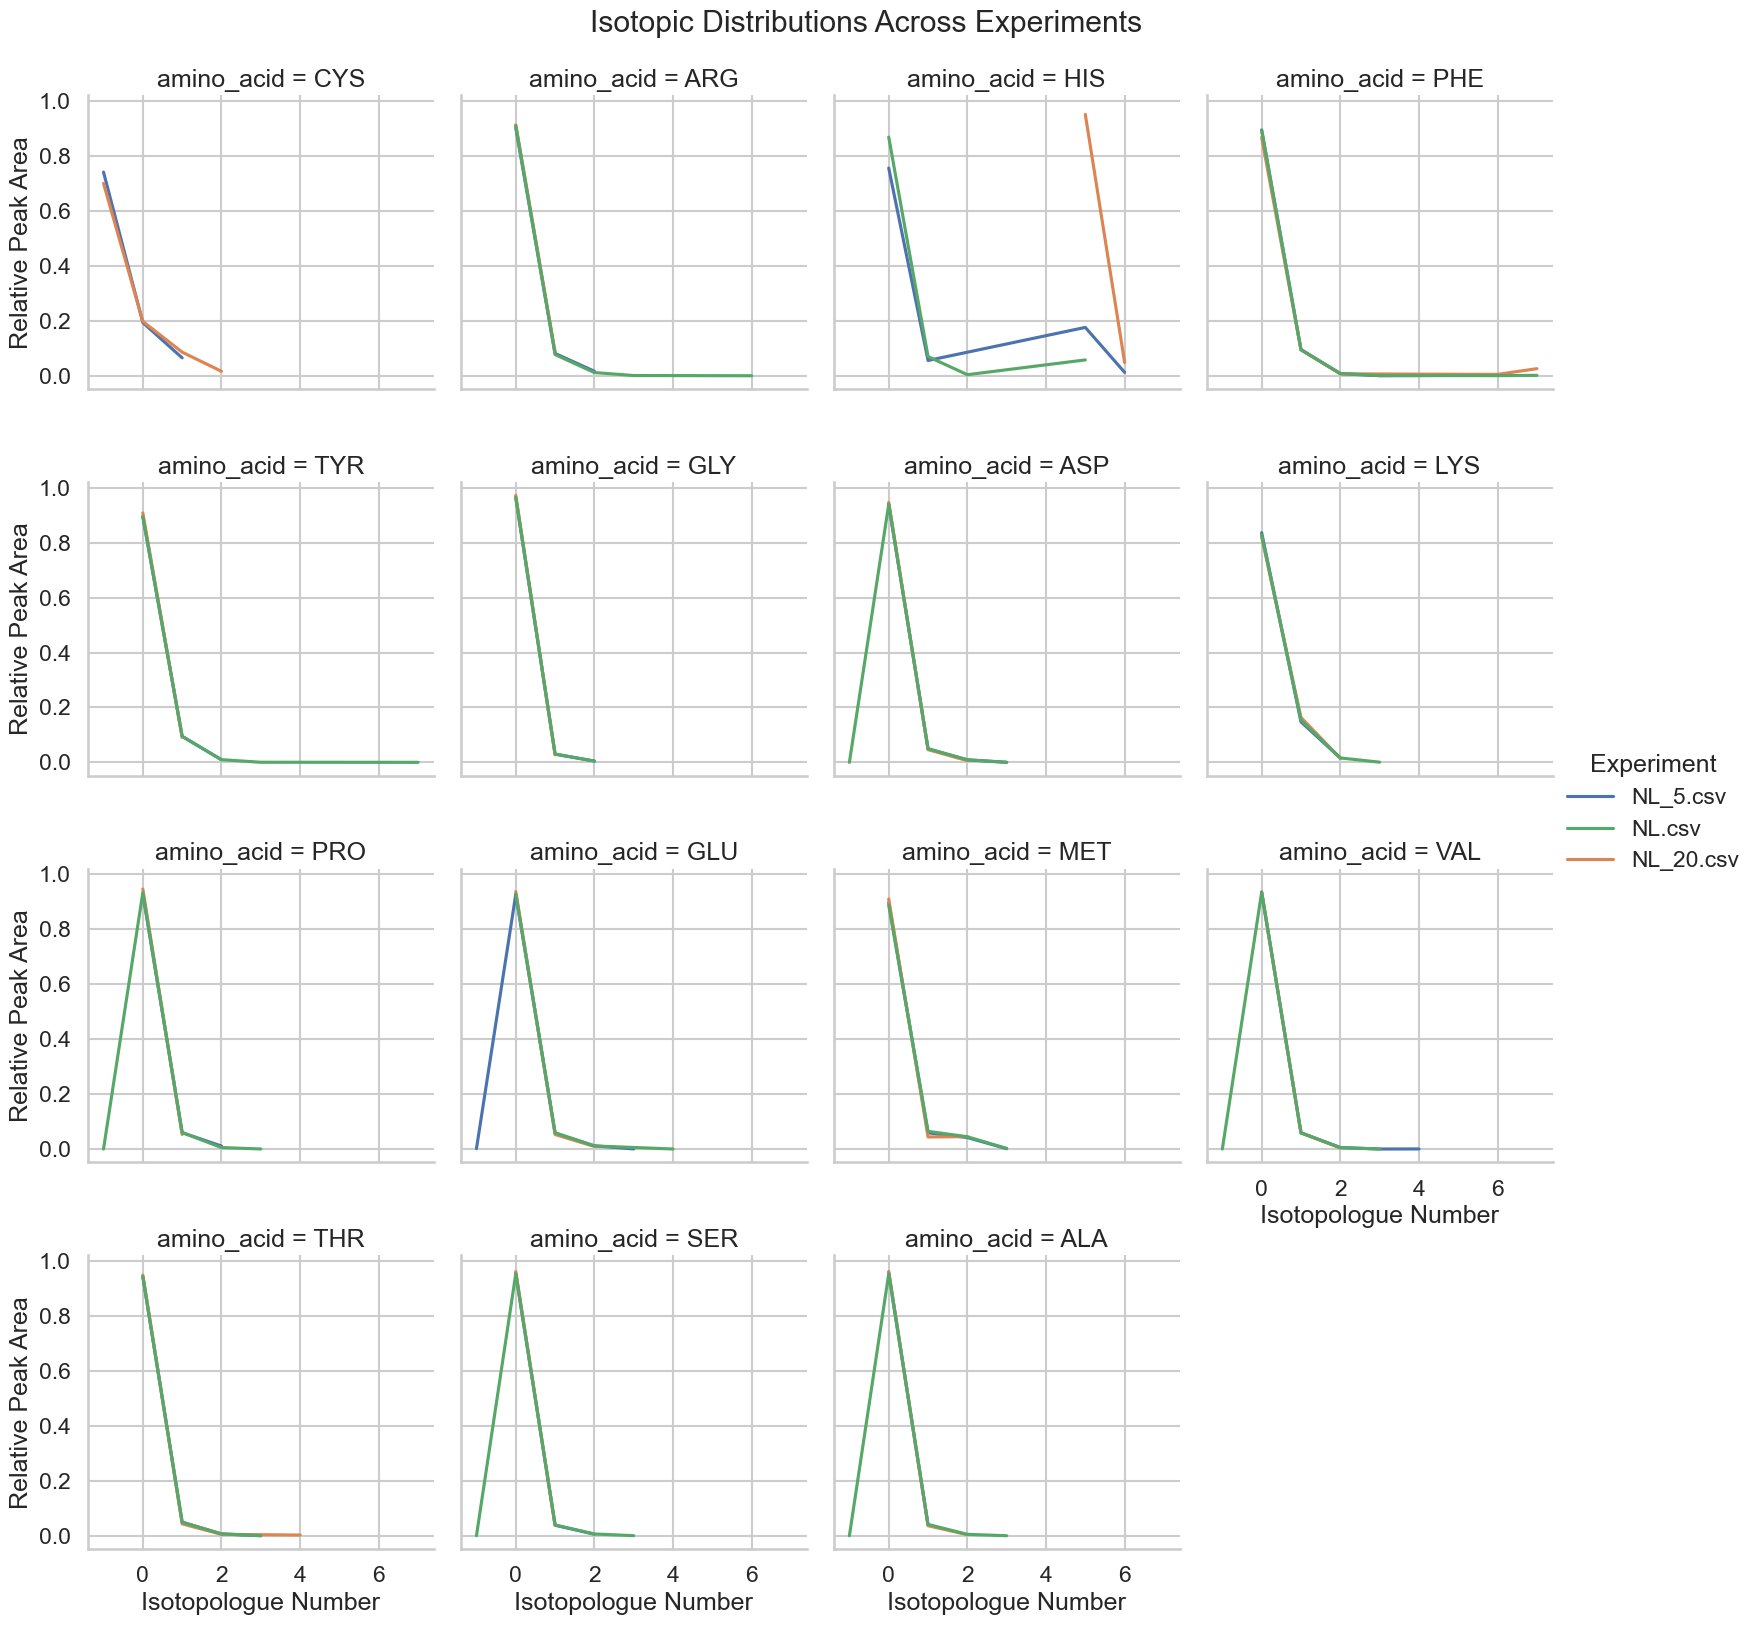

In [183]:
g = sns.FacetGrid(df_all, col="amino_acid", col_wrap=4, height=4, sharey=True)
g.map_dataframe(sns.lineplot, x="isotopologue_number", y="relative_peak_area", hue="experiment")

g.add_legend(title="Experiment")
g.set_axis_labels("Isotopologue Number", "Relative Peak Area")
g.fig.suptitle("Isotopic Distributions Across Experiments", y=1.02)
plt.show()

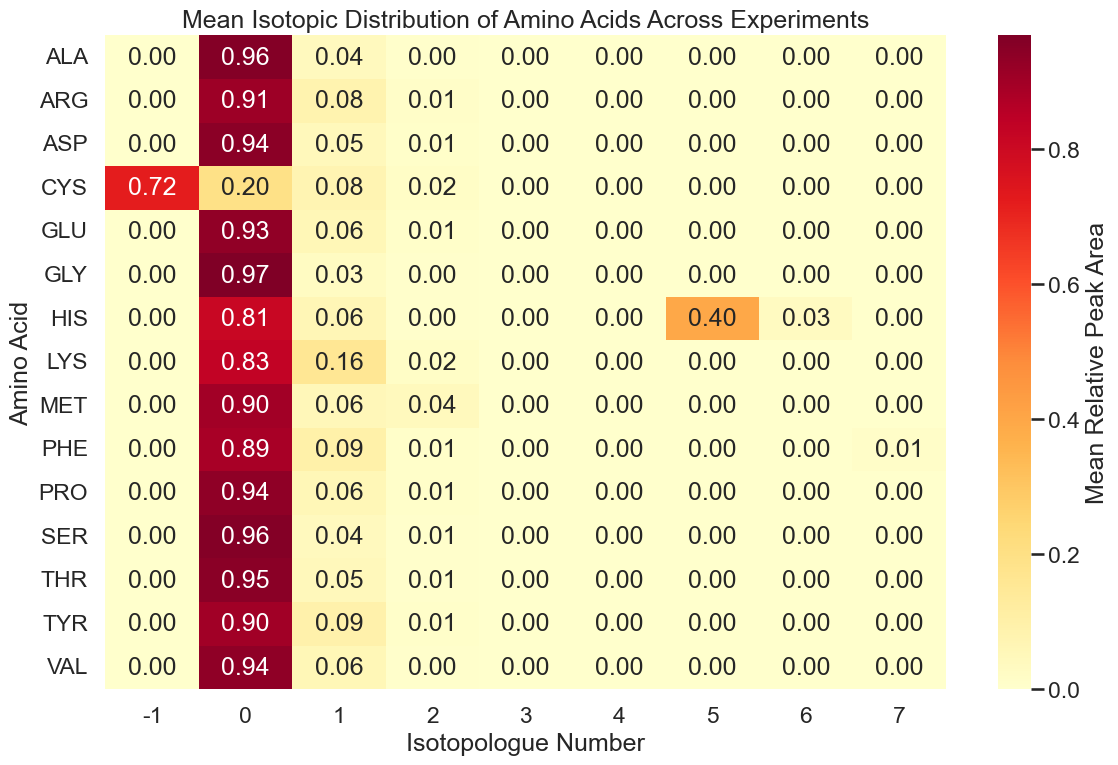

In [184]:
pivot_table = df_all.pivot_table(
    values='relative_peak_area',
    index='amino_acid',
    columns='isotopologue_number',
    aggfunc='mean'
).fillna(0)

for iso in range(-1, 6):
    if iso not in pivot_table.columns:
        pivot_table[iso] = 0
pivot_table = pivot_table[sorted(pivot_table.columns)]

plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt='.2f',
    cmap='YlOrRd',
    cbar_kws={'label': 'Mean Relative Peak Area'}
)
plt.title('Mean Isotopic Distribution of Amino Acids Across Experiments')
plt.xlabel('Isotopologue Number')
plt.ylabel('Amino Acid')
plt.tight_layout()
plt.show()

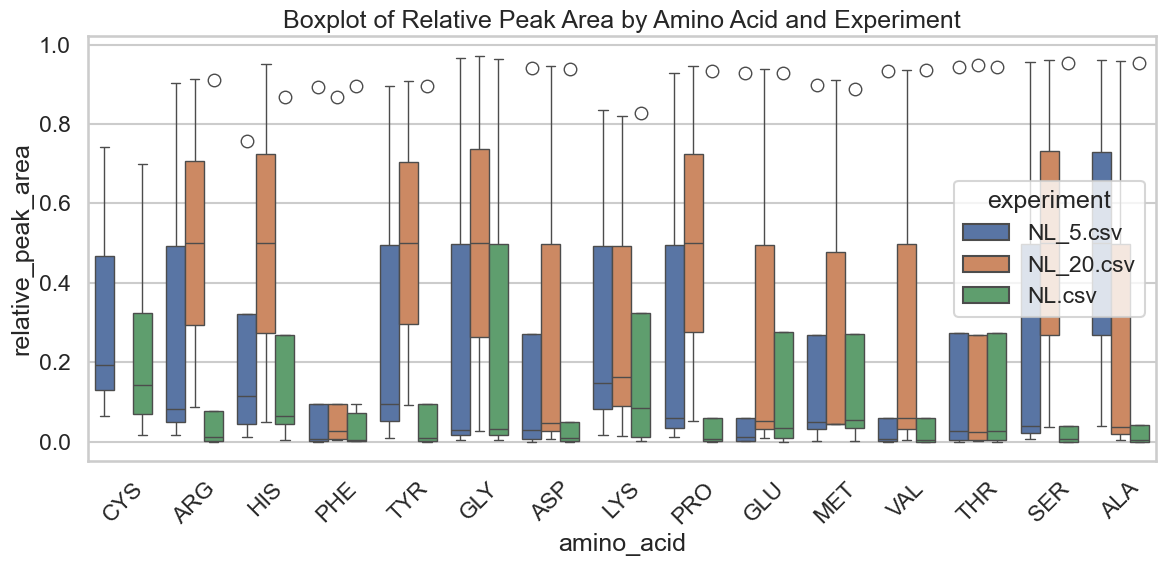

In [185]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_all, x='amino_acid', y='relative_peak_area', hue='experiment')
plt.title("Boxplot of Relative Peak Area by Amino Acid and Experiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

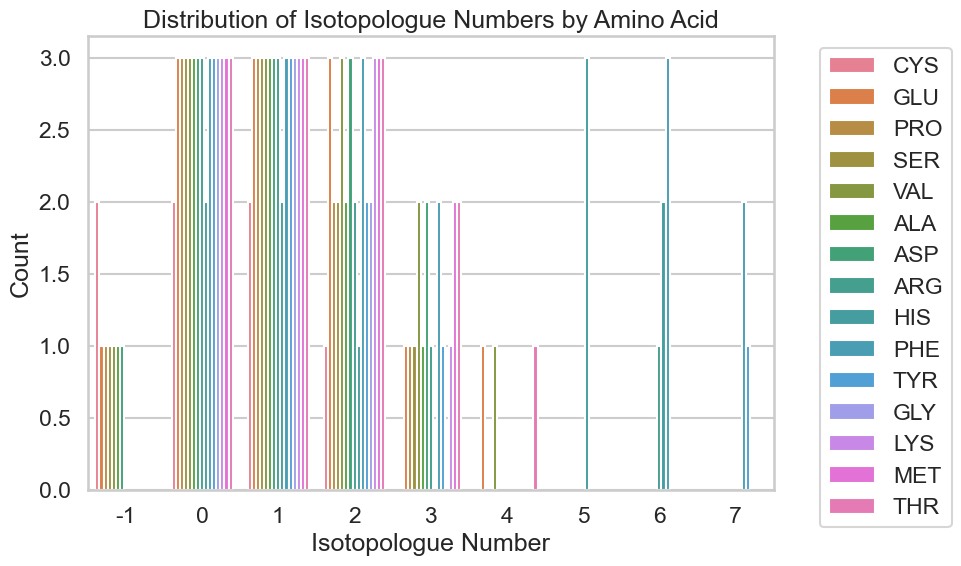

In [186]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_all, x='isotopologue_number', hue='amino_acid')
plt.title("Distribution of Isotopologue Numbers by Amino Acid")
plt.xlabel("Isotopologue Number")
plt.ylabel("Count")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Task 2.
Select an arbitrary UCI repository. Try to visualize the data from that repository. What kind of plots you can use to make representation of data from that repositories more informative? Experiment with different libraries and styles of plots to make your visualization look great.

In [187]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

In [188]:
zoo = fetch_ucirepo(id=111)
X = zoo.data.features
y = zoo.data.targets
data = pd.concat([X, y], axis=1)

print(zoo.metadata)
print(zoo.variables)

data.head()

{'uci_id': 111, 'name': 'Zoo', 'repository_url': 'https://archive.ics.uci.edu/dataset/111/zoo', 'data_url': 'https://archive.ics.uci.edu/static/public/111/data.csv', 'abstract': 'Artificial, 7 classes of animals', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 101, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': [], 'target_col': ['type'], 'index_col': ['animal_name'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1990, 'last_updated': 'Fri Sep 15 2023', 'dataset_doi': '10.24432/C5R59V', 'creators': ['Richard Forsyth'], 'intro_paper': None, 'additional_info': {'summary': 'A simple database containing 17 Boolean-valued attributes.  The "type" attribute appears to be the class attribute.  Here is a breakdown of which animals are in which type: (I find it unusual that there are 2 instances of "frog" and one of "girl"!)', 'purpose': None, 'funded_by': None, 'inst

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
0,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


In [189]:
class_mapping = {
    1: 'Mammal',
    2: 'Bird',
    3: 'Reptile',
    4: 'Fish',
    5: 'Amphibian',
    6: 'Insect',
    7: 'Mollusc/Crustacean'
}
data['class_name'] = data['type'].map(class_mapping)

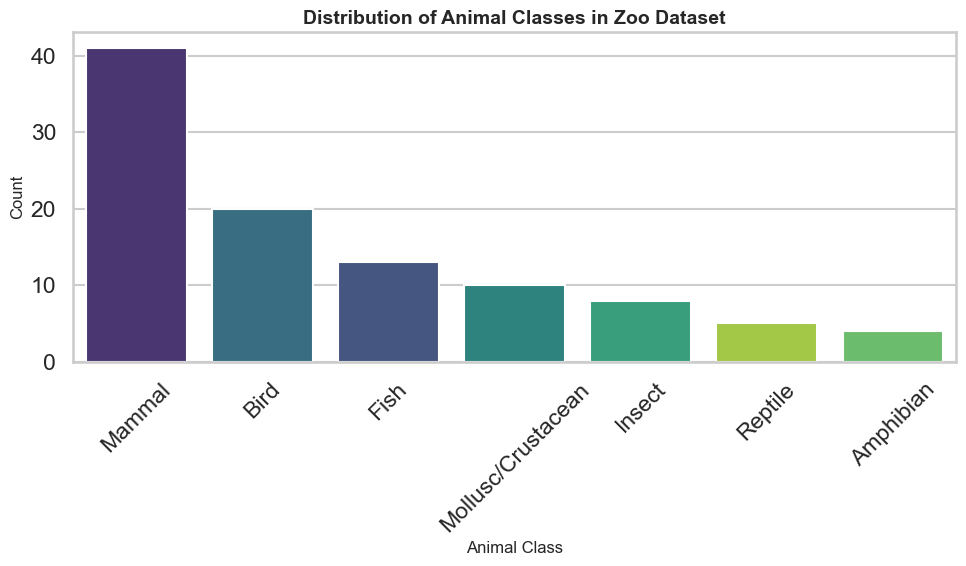

In [190]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.countplot(
    data=data,
    x='class_name',
    hue='class_name',
    palette='viridis',
    order=data['class_name'].value_counts().index,
    legend=False
)
plt.title('Distribution of Animal Classes in Zoo Dataset', fontsize=14, weight='bold')
plt.xlabel('Animal Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [204]:
sns.reset_orig()
sns.set(style="whitegrid")

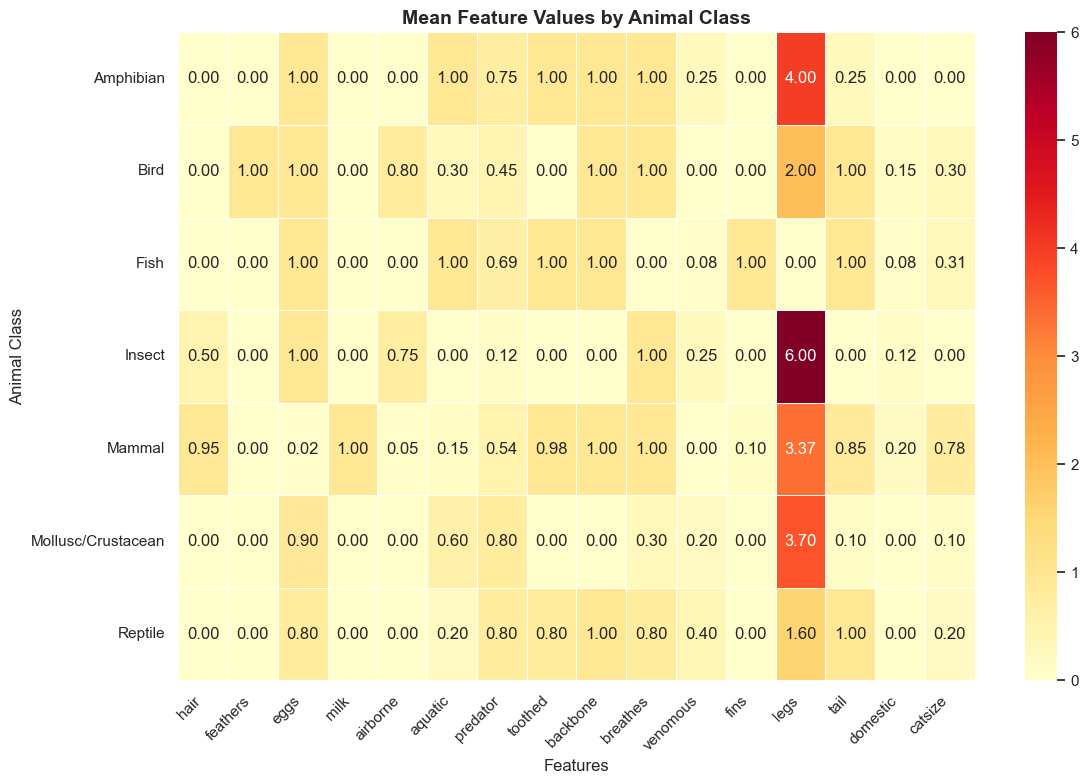

In [205]:
feature_means = data.groupby('class_name').mean().drop(columns=['type'])

plt.figure(figsize=(12, 8))
sns.heatmap(feature_means, annot=True, cmap='YlOrRd', fmt='.2f', linewidths=0.5)
plt.title('Mean Feature Values by Animal Class', fontsize=14, weight='bold')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Animal Class', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

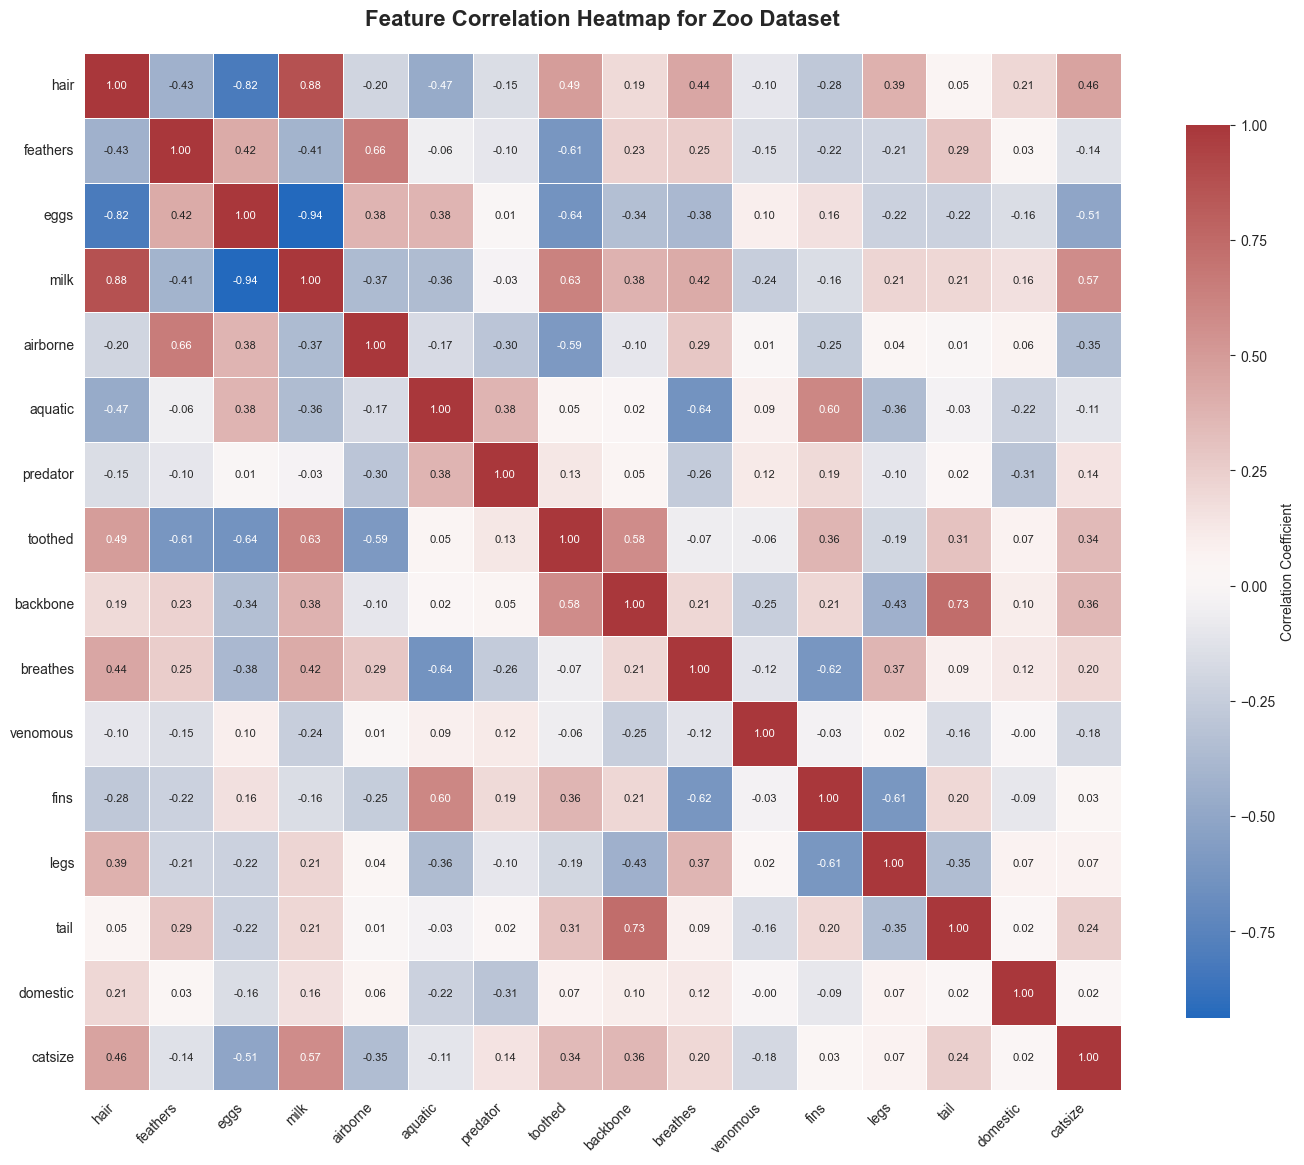

In [193]:
corr_matrix = X.corr()
sns.set_style("whitegrid")

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    annot=True,  
    cmap='vlag', 
    fmt='.2f',   
    linewidths=0.5, 
    square=True,  
    cbar_kws={'label': 'Correlation Coefficient', 'shrink': 0.8}, 
    annot_kws={'size': 8} 
)
plt.title('Feature Correlation Heatmap for Zoo Dataset', fontsize=16, weight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

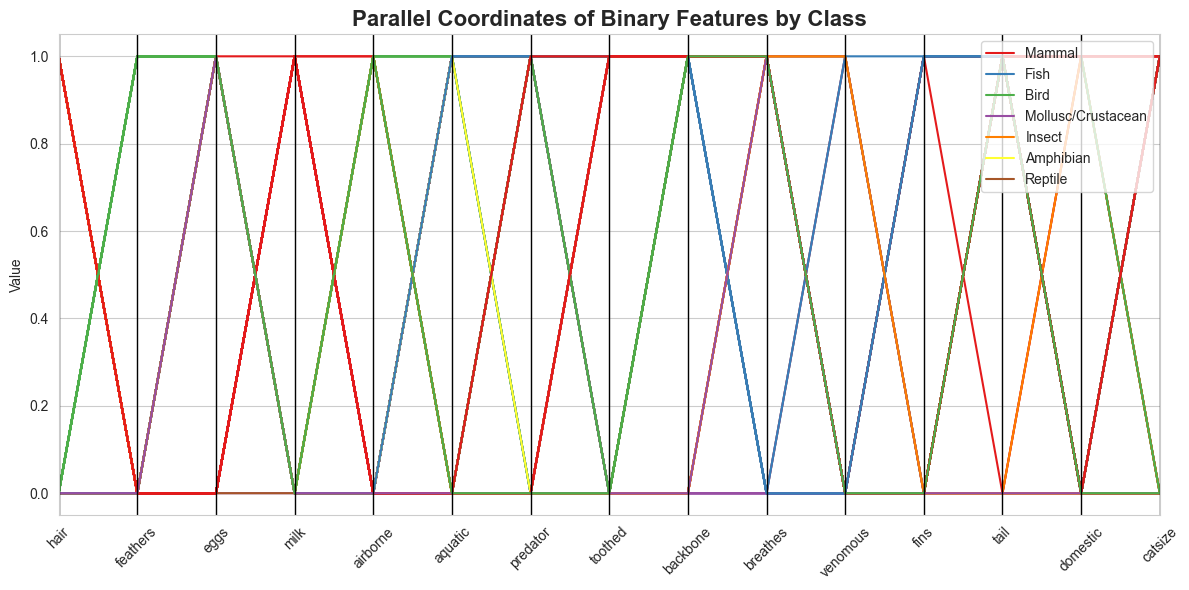

In [194]:
parallel_data = data.drop(columns=['legs', 'type', 'class_name'])
parallel_data['class_name'] = data['class_name']

plt.figure(figsize=(12, 6))
parallel_coordinates(parallel_data, class_column='class_name', color=plt.cm.Set1.colors)

plt.title('Parallel Coordinates of Binary Features by Class', fontsize=16, fontweight='bold')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

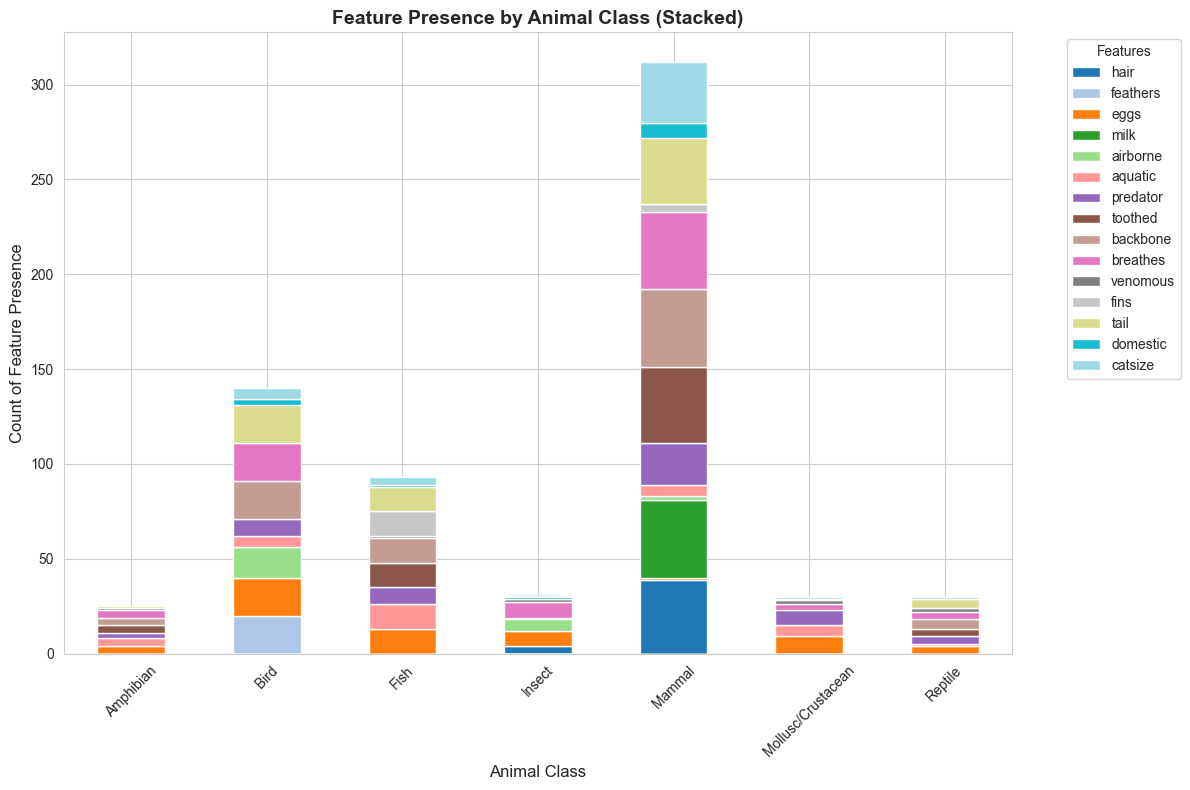

In [195]:
feature_counts = data.groupby('class_name').sum().drop(columns=['type', 'legs'])

feature_counts.plot(kind='bar', stacked=True, figsize=(12, 8), cmap='tab20')
plt.title('Feature Presence by Animal Class (Stacked)', fontsize=14, weight='bold')
plt.xlabel('Animal Class', fontsize=12)
plt.ylabel('Count of Feature Presence', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [196]:
features = ['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'toothed', 'backbone']
class_means = data.groupby('class_name')[features].mean()

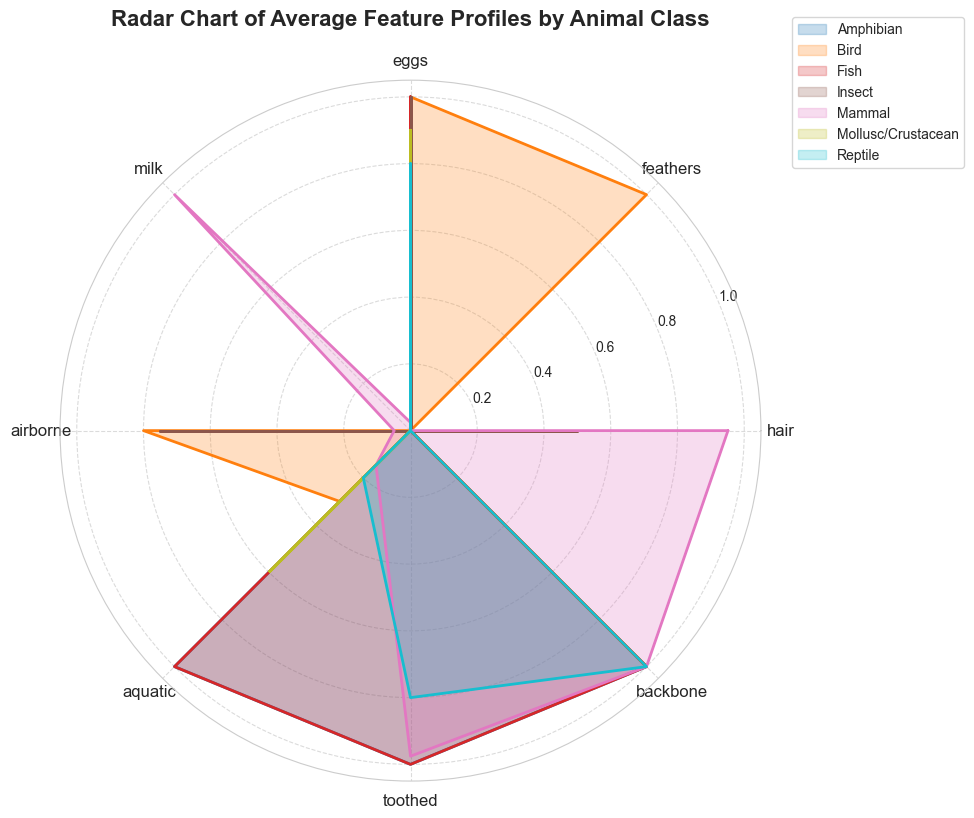

In [197]:
labels = features
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

colors = plt.cm.tab10(np.linspace(0, 1, len(class_means)))
for idx, (class_name, row) in enumerate(class_means.iterrows()):
    values = row.values.tolist()
    values += values[:1]
    ax.fill(angles, values, color=colors[idx], alpha=0.25, label=class_name)
    ax.plot(angles, values, color=colors[idx], linewidth=2)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10)
ax.set_title('Radar Chart of Average Feature Profiles by Animal Class', fontsize=16, weight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

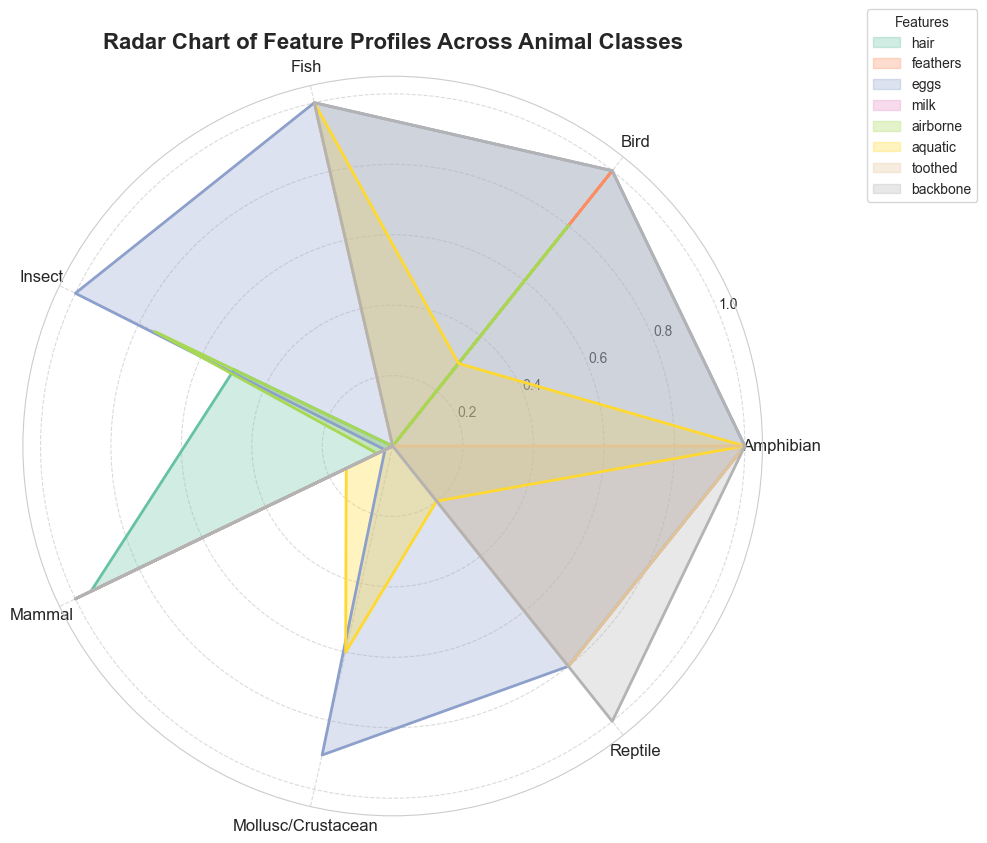

In [198]:
feature_profiles = class_means.T

labels = class_means.index.tolist() 
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1] 

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

colors = plt.cm.Set2(np.linspace(0, 1, len(feature_profiles)))
for idx, (feature, row) in enumerate(feature_profiles.iterrows()):
    values = row.values.tolist()
    values += values[:1] 
    ax.fill(angles, values, color=colors[idx], alpha=0.3, label=feature)
    ax.plot(angles, values, color=colors[idx], linewidth=2)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10)
ax.set_title('Radar Chart of Feature Profiles Across Animal Classes', fontsize=16, weight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10, title='Features')
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

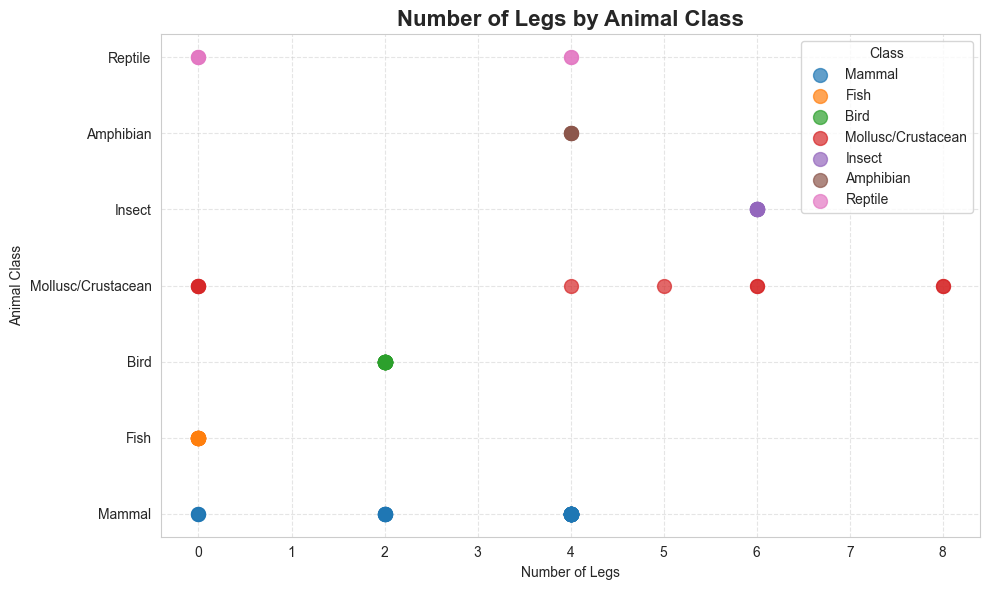

In [199]:
plt.figure(figsize=(10, 6))

for class_name in data['class_name'].unique():
    subset = data[data['class_name'] == class_name]
    plt.scatter(subset['legs'], subset['class_name'], label=class_name, alpha=0.7, s=100)

plt.xlabel('Number of Legs')
plt.ylabel('Animal Class')
plt.title('Number of Legs by Animal Class', fontsize=16, fontweight='bold')
plt.legend(title='Class')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()